## This demo notebook provides code to compute nearest neighbors of an image according to its features computed by ViTMAE. You can use cosine similarity between tokens (encoder's output) or attention weights here. You should compute intermediate features and save them before when planning to compute similarities for a large amount of images. This may be heavy for your disk but it will save you many time for computing similarities.

In [1]:

from collections import defaultdict

import torch
import torchvision.datasets as datasets
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import seaborn as sns

from visualize import to_print,visualize_mae_3pictures,visualize_neighbors,visualize_mae
from utils.load_models import load_mae
from imagenet_utils.extract_batchs import extract_batch,path_init
from dataset import DATA



import os 

current = os.getcwd() #Directory
data_path = current + '\\imagenet'

inet_mean = [0.485, 0.456, 0.406]
inet_std = [0.229, 0.224, 0.225]

# Load model and data

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else('cpu')
print(device)
#Loading VitMAE model pretrained on imagenet 64*64
model = load_mae().to(device)

cuda
Model loaded.


In [3]:
#In this demo we work with validation set
extract = False
train_repo, val_repo = path_init(data_path)
if extract:
    counter,val_counter = extract_batch(data_path+'\\batchs\\',train_repo,val_repo,train=False,val=True,device='cpu') #If having a good CPU, it will run faster on it rather than gpu.
else:
    counter,val_counter = 1281167, 50000
features_repo = data_path + '\\features\\'
if not os.path.exists(features_repo):
    os.mkdir(features_repo)

In [52]:
img_list_inet = [val_repo + str(i)+".pt" for i in range(val_counter)]

imagenet_data = DATA(img_list_inet,mean=inet_mean,std=inet_std) #no transform here

inet_loader = torch.utils.data.DataLoader(imagenet_data,
                         batch_size=512,
                         num_workers=0,
                         shuffle=False)

# We save intermediate features to run multiple computations faster

In [5]:
save = False #False if already saved, or don't need them
if save:
    t = iter(inet_loader)

    for j in tqdm(range(len(inet_loader))):

      with torch.no_grad():
        with torch.cuda.amp.autocast():
          #samples,idxs =  next(iterator)
          samples,idxs =  next(t)

          samples = samples.to('cuda',non_blocking=True)
          idxs = idxs.to('cuda')


          f = model.forward_encoder(samples,mask_ratio = 0)[0][:,1:,:]
          #B,n,dim = f.shape
          #f = f.view(B,n*dim)
          for i in range(len(samples)):
            feature = f[i].clone().cpu()
            id = str(int(idxs[i]))

            f_name = features_repo + id +".pt"
            torch.save(feature,f_name)

In [6]:
class DATA_features(Dataset):
    def __init__(self, img_list, transform = None, mean = None,std = None):
        self.img_list = img_list

        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        f = torch.load(img_path)

        return f,idx

In [7]:
val_features_list = [features_repo + str(i)+".pt" for i in range(val_counter)]

val_features_dataset = DATA_features(val_features_list) #no transform here

val_features_loader = torch.utils.data.DataLoader(val_features_dataset,
                         batch_size=512,
                         num_workers=0,
                         shuffle=False)

# Find an image and compute similarities

()

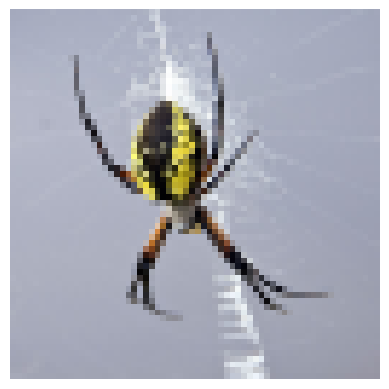

In [63]:
to_print(imagenet_data.__getitem__(3)[0],std = inet_std, mean = inet_mean,show=True)

In [64]:
#script if you don't have saved all the features (need small batch size)
depth=0
ref_id = 3

comparison_method = 'tokens' 
#tokens : euclidian distance similarity between encoders flattened output [supposed SAVED in this script]
#everything : Frobenius norm between attention matrices
#mean : mean attention matrices over depth and heads
comparison_method_bis = ''  #in case you want to use two types of similarities (and leverage them)

def extract_f0(comparison_method,ref_id):
  if comparison_method=='everything' or comparison_method=='mean':
    f_0 =get_attention_matrix(ref_id,depth=comparison_method)
  if comparison_method=='tokens':
    f_0 = val_features_dataset.__getitem__(ref_id)[0]
    n,dim = f_0.shape
    f_0 = f_0.view(n*dim)
  return(f_0)

f_0 = extract_f0(comparison_method,ref_id).to(device)
#f_0bis = extract_f0(comparison_method_bis,ref_id)

l = 100
to_beat = -100000
top_sim = -100000*torch.ones(l,2).to(device)
i=0

t = iter(val_features_loader)

with torch.no_grad():
  for i in tqdm(range(len(val_features_loader))): #use imagenet loader if you want to use unsaved features like attention matrices

    #samples,idxs =  next(iterator)

    samples,idxs =  next(t)
    samples = samples.to(device,non_blocking=True)
    idxs = idxs.to(device)
    with torch.cuda.amp.autocast():

      #f = (torch.sum(f[:,depth,:,:,:],dim=1)/f.shape[2])
      if comparison_method == 'everything':
        #f = f[:,:5]
        similarities = frobenius_sim_allmatrices(f_0,rel_atts)
      elif comparison_method == 'mean':
        f = torch.mean(torch.mean(rel_atts,dim=2),dim=1) #mean over depth and layers on attention matrices
        similarities = frobenius_batch_neg(f_0,f)
      elif comparison_method =='tokens':
        f = samples
        B,n,dim = f.shape
        f = f.view(B,n*dim)
        similarities = -((f_0-f)**2).sum(dim=1) #F.cosine_similarity(f_0,f)
      
      if comparison_method_bis=='everything': #script to be continued to add more merging options between metrics
        torch.cuda.synchronize()
        similarities = similarities + frobenius_sim_allmatrices(f_0bis,rel_atts)
      

    best_of_batch = torch.max(similarities)

    if best_of_batch>to_beat:
      sim_batch = torch.stack((similarities,idxs)).T #is now tupls of sim,id
      to_sort = torch.cat([sim_batch,top_sim])
      to_sort = to_sort[to_sort[:, 0].sort(descending=True)[1]][:l] #sort ccording to sim
      top_sim = to_sort
      to_beat = top_sim[:,0].min()
    torch.cuda.synchronize()
    '''if not top_sim[0,1]==ref_id: #after == is img id. You can only use this check if ref_id < batch size.
      print('Erreur : ',i)
      break
    '''
    i+=1
#to do : mean between two sims

100%|██████████| 98/98 [00:12<00:00,  7.83it/s]


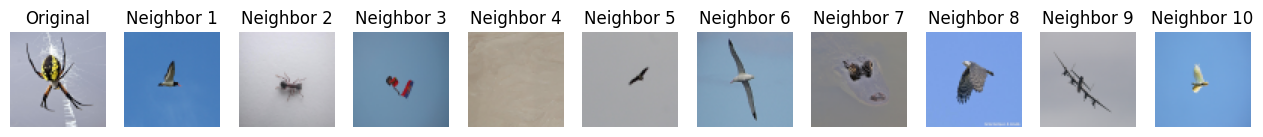

In [65]:
visualize_neighbors(top_sim.T[1].int(),imagenet_data,ref_id,10,inet_std,inet_mean)